
#GNN Node Clustering - Google Colab Notebook

Complete implementation for training GNNs to cluster graph nodes.
Ready to run on Google Colab with GPU support.

To use:
1. Copy this entire file
2. Open Google Colab (colab.research.google.com)
3. Create new notebook
4. Paste code into cells as indicated below
5. Run cells in order


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# --- 指定数据文件储存地址 ---
import os
from pathlib import Path

# --- Project Root ---
PROJECT_ROOT = Path("/content/drive/MyDrive/GNN-MILP")

# --- Base Directories ---
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

PROBLEM = 'osif'
# PROBLEM = 'facilities'

# --- Data Subdirectories ---
RAW_DATA_DIR = DATA_DIR / PROBLEM /"raw"
MPS_DATA_DIR = DATA_DIR / PROBLEM / "mps"
PROCESSED_DATA_DIR = DATA_DIR / PROBLEM

# Install PyTorch Geometric

In [3]:
!pip install torch
!pip install torch_geometric
!pip install scikit-learn matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.2 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


# CELL 3: GNN Model Architectures

In [5]:
class SimpleGCN(nn.Module):
    """Graph Convolutional Network - Simple and effective."""

    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, num_classes)
        self.p = 0.3

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.p, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.p, training=self.training)

        x = self.conv3(x, edge_index)
        embeddings = F.relu(x)

        logits = self.classifier(embeddings)
        return logits, embeddings


class SimpleGAT(nn.Module):
    """Graph Attention Network - Uses attention mechanism."""

    def __init__(self, in_channels, hidden_channels, num_classes, heads=2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.3)
        # self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=0.3)
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=0.3)
        self.classifier = nn.Linear(hidden_channels, num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # x = self.conv2(x, edge_index)
        # x = F.relu(x)

        x = self.conv3(x, edge_index)
        embeddings = F.relu(x)

        logits = self.classifier(embeddings)
        return logits, embeddings


class SimpleSAGE(nn.Module):
    """GraphSAGE - Samples and aggregates neighbor features."""

    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, num_classes)
        self.p = 0.2

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.p, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.p, training=self.training)

        x = self.conv3(x, edge_index)
        embeddings = F.relu(x)

        logits = self.classifier(embeddings)
        return logits, embeddings


print("✓ GNN architectures defined: GCN, GAT, SAGE")


✓ GNN architectures defined: GCN, GAT, SAGE


# CELL 4: Training & Evaluation

In [6]:
class Trainer:
    """Handles model training and evaluation."""

    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'val_ari': [], 'val_nmi': []
        }

    def train_epoch(self, loader, optimizer, criterion):
        """Single training epoch."""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for data in loader:
            data = data.to(self.device)
            optimizer.zero_grad()

            logits, _ = self.model(data)
            # Cast target labels to Long
            loss = criterion(logits, data.y.long())
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.num_nodes
            correct += (logits.argmax(1) == data.y).sum().item()
            total += data.num_nodes

        return total_loss / total, correct / total

    def evaluate(self, loader, criterion):
        """Evaluate on validation/test set."""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for data in loader:
                data = data.to(self.device)
                logits, _ = self.model(data)
                # Cast target labels to Long
                loss = criterion(logits, data.y.long())

                total_loss += loss.item() * data.num_nodes
                pred = logits.argmax(1)
                correct += (pred == data.y).sum().item()
                total += data.num_nodes

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(data.y.cpu().numpy())

        ari = adjusted_rand_score(all_labels, all_preds)
        nmi = normalized_mutual_info_score(all_labels, all_preds)

        return total_loss / total, correct / total, ari, nmi

    def train(self, train_loader, val_loader, num_epochs=50, lr=0.01):
        """Full training loop with progress bar."""
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()
        best_val_acc = 0

        pbar = tqdm(range(num_epochs), desc="Training")
        for epoch in pbar:
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc, val_ari, val_nmi = self.evaluate(val_loader, criterion)

            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_ari'].append(val_ari)
            self.history['val_nmi'].append(val_nmi)

            # Save best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.best_state = self.model.state_dict()

            # Update progress bar
            pbar.set_postfix({
                'train_acc': f'{train_acc:.3f}',
                'val_acc': f'{val_acc:.3f}',
                'val_ari': f'{val_ari:.3f}'
            })

        # Restore best model
        self.model.load_state_dict(self.best_state)
        return self.history

print("✓ Trainer class ready")

✓ Trainer class ready


# Configuration

In [7]:
CONFIG = {
    'hidden_channels': 64,
    'num_epochs': 10,
    'lr': 0.0008,
    'batch_size': 32,
    'weight_decay': 5e-4
}

print("\nConfiguration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")


Configuration:
  hidden_channels: 64
  num_epochs: 10
  lr: 0.0008
  batch_size: 32
  weight_decay: 0.0005


# Train All Models

In [8]:
import glob
import multiprocessing
from torch_geometric.data import HeteroData
from functools import partial
import scipy.sparse
from scipy.sparse.csgraph import shortest_path
import networkx as nx

In [9]:
def load_facility_data(data_dir, split='train'):
    """加载设施选址问题的数据"""
    data_path = os.path.join(data_dir, split)

    all_files = glob.glob(os.path.join(data_path, '*.pt'))
    dataset = []

    for file_path in all_files:
        # 加载异构图数据
        # Set weights_only=False to handle PyTorch version compatibility
        hetero_data = torch.load(file_path, weights_only=False)

        # 创建同构图数据
        # 使用variable节点的特征和标签
        data = Data(
            x=hetero_data['variable'].x,
            y=hetero_data['variable'].y,
            # 使用variable到constraint的边
            edge_index=hetero_data['variable', 'in', 'constraint'].edge_index
        )
        dataset.append(data)

    return dataset

In [10]:
processed_data_dir = PROCESSED_DATA_DIR
train_graphs = load_facility_data(processed_data_dir, 'train')
val_graphs = load_facility_data(processed_data_dir, 'valid')
test_graphs = load_facility_data(processed_data_dir,'test')

print(f"✓ 训练集: {len(train_graphs)} 个图")
print(f"✓ 验证集: {len(val_graphs)} 个图")
print(f"✓ 测试集: {len(test_graphs)} 个图")

✓ 训练集: 1200 个图
✓ 验证集: 250 个图
✓ 测试集: 250 个图


In [11]:
in_channels = train_graphs[0].x.shape[1]
num_classes = len(torch.unique(train_graphs[0].y))
print(f"✓ Input channels: {in_channels}")
print(f"✓ Output classes: {num_classes}")

✓ Input channels: 37
✓ Output classes: 50


In [12]:
# 创建数据加载器
train_loader = DataLoader(train_graphs, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=CONFIG['batch_size'])
test_loader = DataLoader(test_graphs, batch_size=CONFIG['batch_size'])

print(f"\n✓ 数据加载器已创建")
print(f"  训练集批次数: {len(train_loader)}")
print(f"  验证集批次数: {len(val_loader)}")
print(f"  测试集批次数: {len(test_loader)}")


✓ 数据加载器已创建
  训练集批次数: 38
  验证集批次数: 8
  测试集批次数: 8


# Initialize models

In [13]:
models = {
    'GCN': SimpleGCN(in_channels, CONFIG['hidden_channels'], num_classes),
    'GAT': SimpleGAT(in_channels, CONFIG['hidden_channels'], num_classes),
    'SAGE': SimpleSAGE(in_channels, CONFIG['hidden_channels'], num_classes),
}

results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print('='*60)

    trainer = Trainer(model, device=device)
    history = trainer.train(
        train_loader, val_loader,
        num_epochs=CONFIG['num_epochs'],
        lr=CONFIG['lr']
    )

    # Evaluate on test set
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, test_ari, test_nmi = trainer.evaluate(test_loader, criterion)

    results[name] = {
        'test_acc': test_acc,
        'test_ari': test_ari,
        'test_nmi': test_nmi,
        'history': history,
        'trainer': trainer
    }

    print(f"\n{name} Test Results:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  ARI: {test_ari:.4f}")
    print(f"  NMI: {test_nmi:.4f}")

    # 保存最佳模型
    model_save_path = os.path.join(MODELS_DIR, 'facilities', name)
    os.makedirs(model_save_path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_save_path, 'model.pt'))
    print(f"\n模型已保存至 {model_save_path}")


Training GCN


Training: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it, train_acc=0.824, val_acc=0.832, val_ari=0.598]



GCN Test Results:
  Accuracy: 0.8315
  ARI: 0.5980
  NMI: 0.4224

模型已保存至 /content/drive/MyDrive/GNN-MILP/models/facilities/GCN

Training GAT


Training: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it, train_acc=0.828, val_acc=0.822, val_ari=0.000]



GAT Test Results:
  Accuracy: 0.8225
  ARI: 0.0000
  NMI: 0.0000

模型已保存至 /content/drive/MyDrive/GNN-MILP/models/facilities/GAT

Training SAGE


Training: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it, train_acc=0.826, val_acc=0.832, val_ari=0.961]



SAGE Test Results:
  Accuracy: 0.8315
  ARI: 0.9606
  NMI: 0.6585

模型已保存至 /content/drive/MyDrive/GNN-MILP/models/facilities/SAGE


# CELL 7: Visualize Results


FINAL RESULTS COMPARISON

Model      Accuracy     ARI          NMI         
------------------------------------------------------------
GCN        0.8315       0.5980       0.4224      
GAT        0.8225       0.0000       0.0000      
SAGE       0.8315       0.9606       0.6585      


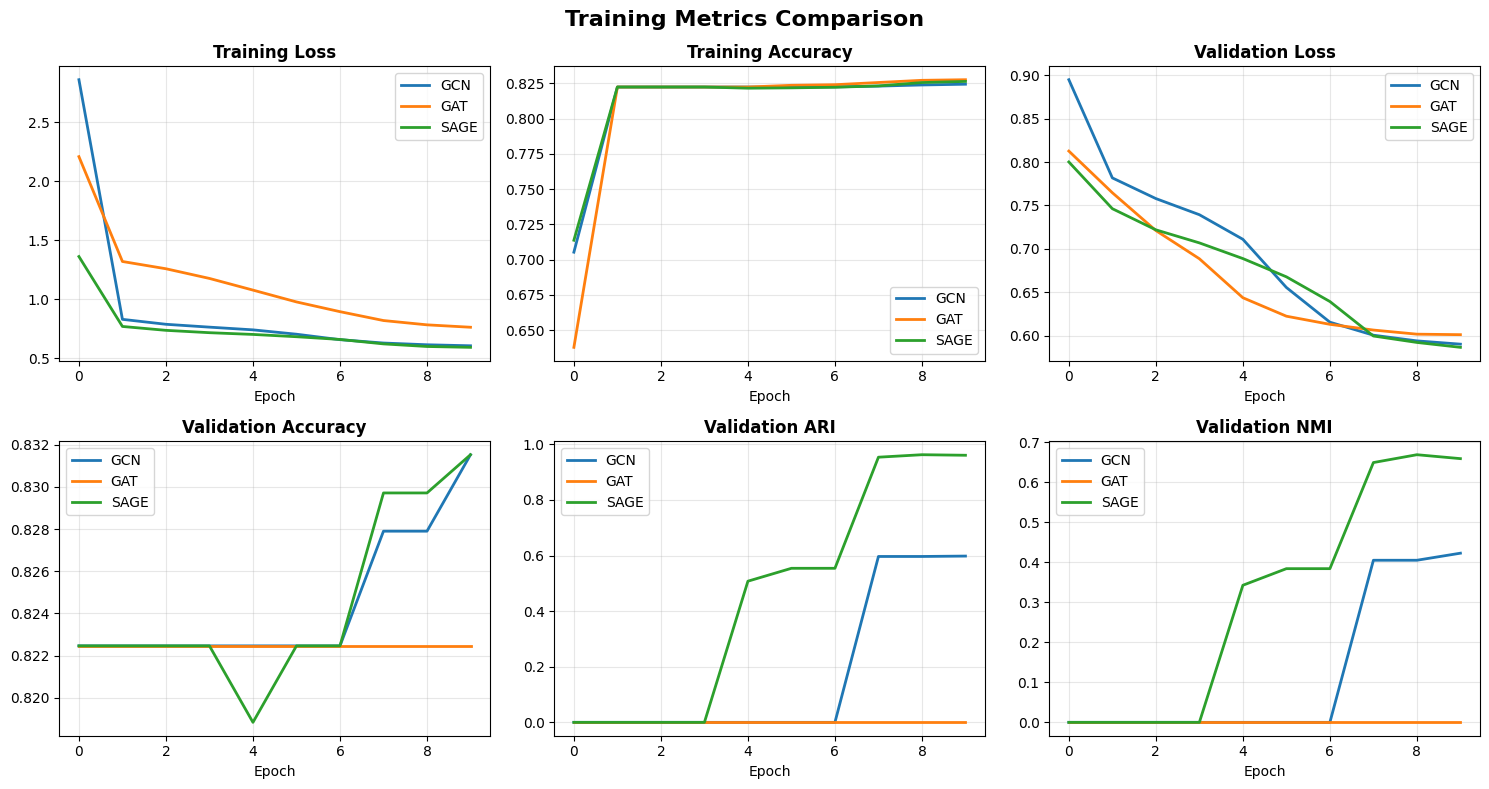

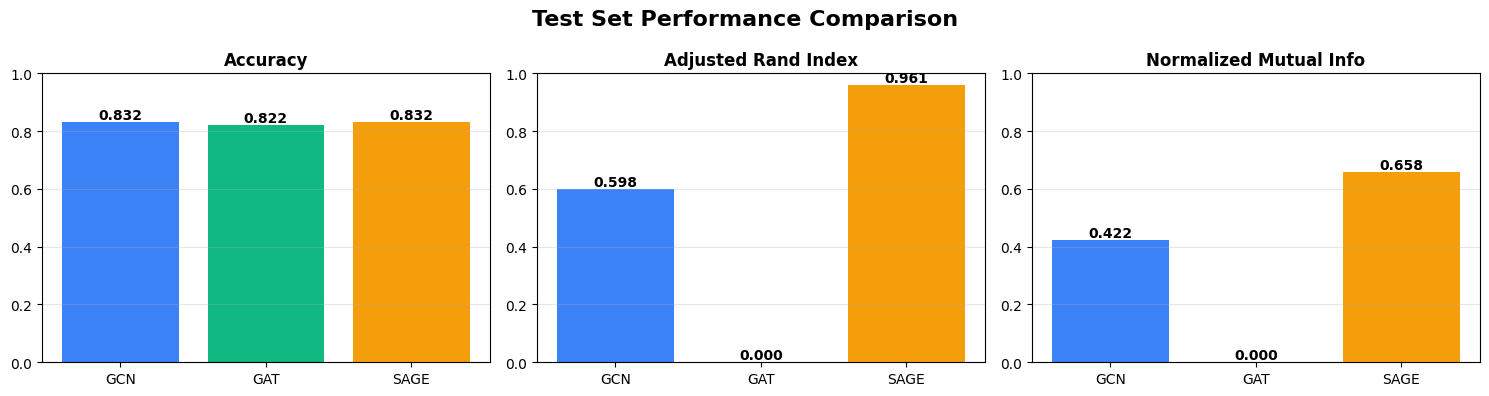


✓ All visualizations complete!


In [15]:
print("\n" + "=" * 60)
print("FINAL RESULTS COMPARISON")
print("=" * 60)

# Print comparison table
print(f"\n{'Model':<10} {'Accuracy':<12} {'ARI':<12} {'NMI':<12}")
print("-" * 60)
for name, res in results.items():
    print(f"{name:<10} {res['test_acc']:<12.4f} {res['test_ari']:<12.4f} {res['test_nmi']:<12.4f}")

# Plot training curves for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Training Metrics Comparison', fontsize=16, fontweight='bold')

metrics = [
    ('train_loss', 'Training Loss'),
    ('train_acc', 'Training Accuracy'),
    ('val_loss', 'Validation Loss'),
    ('val_acc', 'Validation Accuracy'),
    ('val_ari', 'Validation ARI'),
    ('val_nmi', 'Validation NMI')
]

for idx, (metric, title) in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    for name, res in results.items():
        ax.plot(res['history'][metric], label=name, linewidth=2)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Test Set Performance Comparison', fontsize=16, fontweight='bold')

metrics_bar = [
    ('test_acc', 'Accuracy'),
    ('test_ari', 'Adjusted Rand Index'),
    ('test_nmi', 'Normalized Mutual Info')
]

for idx, (metric, title) in enumerate(metrics_bar):
    ax = axes[idx]
    values = [results[name][metric] for name in models.keys()]
    bars = ax.bar(models.keys(), values, color=['#3b82f6', '#10b981', '#f59e0b'])
    ax.set_title(title, fontweight='bold')
    ax.set_ylim(0, 1.0)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ All visualizations complete!")